# License Status Prediction - Multiclass Classification
<hr style="border:1px solid gray"> </hr>

In [1]:
pip install category_encoders


  Using cached category_encoders-2.5.1.post0-py2.py3-none-any.whl (72 kB)
Note: you may need to restart the kernel to use updated packages.


## Contents.

    1. Problem Description
    2. Data Exploration
    3. Feature Selection
    4. KNN Algorithm
    5. Naive Bias
    5. Logistic Regression
    6. Decisoin Tree
    
    
--------------------------------------------------------------------------------------------------------------------------------


### Problem Description

We are given a license dataset which holds various information related the business license , The objective of out problem is to predict license Status for the given business. Lets start with delving deep into the data.
________________________________________________________________________________________________________________________________

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import category_encoders as ce

In [2]:

df = pd.read_csv("License_data.csv")

print(df.shape)

# show the top few rows
display(df.head().T)

(85895, 32)


C:\Users\ranbi\AppData\Local\Temp\ipykernel_60884\3980253677.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("License_data.csv")


,0,1,2,3,4
ID,35342-20020816,1358463-20051116,1980233-20090722,1476582-20040211,1141408-20080516
LICENSE ID,1256593,1639294,1980233,1476582,1896750
ACCOUNT NUMBER,32811,262311,345008,273121,213785
SITE NUMBER,1,29,1,1,1
LEGAL NAME,CARMEN CAHUE,"ISLA TROPICAL, INC.",DJS REMODELING,ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
DOING BUSINESS AS NAME,CLAUDIA'S BRIDAL SHOP,ISLA TROPICAL,"DJS REMODELING, INC.",ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
ADDRESS,2625 S CENTRAL PARK AVE 1,2825 W MONTROSE AVE,1605 CLAVEY RD 1,8 NORTH TRAIL,4081 JOSEPH DR
CITY,CHICAGO,CHICAGO,HIGHLAND,LEMONT,WAUKEGAN
STATE,IL,IL,IL,IL,IL
ZIP CODE,60623.0,60618,60035,60439,60087


In [3]:
# change the columns name
new_col_name = [col.replace(" ","_").lower() for col in df.columns]
df.columns = new_col_name

In [4]:
df.columns

Index(['id', 'license_id', 'account_number', 'site_number', 'legal_name',
       'doing_business_as_name', 'address', 'city', 'state', 'zip_code',
       'ward', 'precinct', 'ward_precinct', 'police_district', 'license_code',
       'license_description', 'license_number', 'application_type',
       'application_created_date', 'application_requirements_complete',
       'payment_date', 'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued', 'license_status_change_date', 'ssa', 'latitude',
       'longitude', 'location', 'license_status'],
      dtype='object')

## Data Cleansing

1. Missing Values - lot of missing data for particular variables
2. Unique Data - id (no meaning)
3. Data leakage - The AAI alone doesn't have licesnse status change value (as the license are never revoked/cancelled) 


In [5]:
df.isnull().sum()

id                                       0
license_id                               0
account_number                           0
site_number                              0
legal_name                               0
doing_business_as_name                   1
address                                  0
city                                     0
state                                    0
zip_code                                31
ward                                 49701
precinct                             56701
ward_precinct                        49700
police_district                      54012
license_code                             0
license_description                      0
license_number                           1
application_type                         0
application_created_date             64660
application_requirements_complete      214
payment_date                          1289
conditional_approval                     0
license_term_start_date                228
license_ter

In [6]:

drop_col_list = ["id","license_id","ssa","location","application_created_date","account_number","address"]
df = df.drop(drop_col_list, axis=1)

In [7]:
df["license_status_change"] = np.where(df.license_status_change_date.isnull(),1,0)

In [8]:
pd.crosstab(df.license_status_change,df.license_status)

license_status,AAC,AAI,INQ,REA,REV
license_status_change,,,,,
0,30200,0,2,3,290
1,0,55400,0,0,0


## Data Transformation
1. Timeline creation
2. Encoding
3. New Feature

In [9]:
# convert string object into date
df.application_requirements_complete = pd.DatetimeIndex(df.application_requirements_complete)
df.payment_date = pd.DatetimeIndex(df.payment_date)
df.license_term_start_date = pd.DatetimeIndex(df.license_term_start_date)
df.license_term_expiration_date = pd.DatetimeIndex(df.license_term_expiration_date)
df.license_approved_for_issuance = pd.DatetimeIndex(df.license_approved_for_issuance)
df.date_issued = pd.DatetimeIndex(df.date_issued)

In [10]:
# Find no.of days btw different application status date
df["completion_to_start"] = (df.license_term_start_date - df.application_requirements_complete).dt.days
df["start_to_expiry"] =  (df.license_term_expiration_date - df.license_term_start_date).dt.days
df["approval_to_issuance"] = (df.date_issued - df.license_approved_for_issuance).dt.days
df["completion_to_payment"] = (df.payment_date - df.application_requirements_complete).dt.days

df["presence_of_enquiry_details"] = np.where(df.ward.isnull() | df.ward_precinct.isnull() | df.police_district | df.precinct , 0 ,1 )

df["target"] = df[['license_status']].apply(lambda col:pd.Categorical(col).codes)

In [11]:
df.city.unique()

array(['CHICAGO', 'HIGHLAND', 'LEMONT', ..., 'ABERDEEN', 'PENSACOLA',
       'MACHESNEY PARK'], dtype=object)

In [12]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))
print(y_onehot.columns)

Index(['target_1', 'target_2', 'target_3', 'target_4', 'target_5'], dtype='object')


C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Target Encoding

In [13]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))

class_names=y_onehot.columns
for class_ in class_names:
  enc=ce.TargetEncoder(smoothing=0)
  temp = enc.fit_transform(df[["license_description","state","city"]],y_onehot[class_])
  temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
  df = pd.concat([df,temp],axis=1)

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categor

### Class Imbalance 

In [14]:
df.license_status.value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: license_status, dtype: int64

In [15]:
df.license_status.value_counts(normalize=True).mul(100).round(3).astype(str) + '%'

AAI    64.497%
AAC    35.159%
REV     0.338%
REA     0.003%
INQ     0.002%
Name: license_status, dtype: object

## over sampling/under sampling

In [16]:
np.sort(df.target.unique()).tolist()

[0, 1, 2, 3, 4]

In [17]:
df_0 = df[df.target==0].sample(frac=0.3,replace=False)
df_1 = df[df.target==1].sample(frac=0.3,replace=False)

df_2 = df[df.target==2].sample(frac=200,replace=True)
df_3 = df[df.target==3].sample(frac=100,replace=True)
df_4 = df[df.target==4].sample(frac=2,replace=True)

sampled_df = pd.concat([df_0,df_1,df_2,df_3,df_4])

sampled_df.target.value_counts()

1    16620
0     9060
4      580
2      400
3      300
Name: target, dtype: int64

## Train / Test Data Preparation

In [18]:
X = sampled_df[['latitude', 'longitude',
       'completion_to_start',
       'start_to_expiry', 'approval_to_issuance', 'completion_to_payment',
       'presence_of_enquiry_details',  'license_description_target_1',
       'state_target_1', 'city_target_1', 'license_description_target_2',
       'state_target_2', 'city_target_2', 'license_description_target_3',
       'state_target_3', 'city_target_3', 'license_description_target_4',
       'state_target_4', 'city_target_4', 'license_description_target_5',
       'state_target_5', 'city_target_5']]

y = sampled_df['target']

In [19]:
# mean imputation
X = X.fillna(X.mean())

In [20]:
# Train/test preparation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

## Modeling

In [21]:

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

In [22]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
knn_model.fit((scaler.transform(X_train)),y_train)
scaler.fit(X_test)
y_pred = knn_model.predict(scaler.transform(X_test))

In [23]:
# Metrics Performance
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74       877
           1       0.92      0.81      0.86      1688
           2       0.00      0.00      0.00        31
           3       0.94      1.00      0.97        30
           4       0.61      0.63      0.62        70

    accuracy                           0.81      2696
   macro avg       0.63      0.66      0.64      2696
weighted avg       0.82      0.81      0.81      2696



C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.37      0.45       877
           1       0.71      0.90      0.80      1688
           2       0.00      0.00      0.00        31
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        70

    accuracy                           0.68      2696
   macro avg       0.26      0.25      0.25      2696
weighted avg       0.63      0.68      0.64      2696



C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Metrics Performance
print(confusion_matrix(y_test,y_pred))

[[ 321  555    1    0    0]
 [ 161 1524    2    1    0]
 [   0   31    0    0    0]
 [  30    0    0    0    0]
 [  46   24    0    0    0]]


In [29]:
# Naive Bias
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
y_pred = nb_model.fit(X_train, y_train).predict(X_test)

In [30]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.30      0.04      0.07       877
           1       0.91      0.85      0.88      1688
           2       1.00      1.00      1.00        31
           3       0.23      1.00      0.38        30
           4       0.07      0.83      0.13        70

    accuracy                           0.59      2696
   macro avg       0.50      0.74      0.49      2696
weighted avg       0.68      0.59      0.59      2696



In [31]:
print(confusion_matrix(y_test,y_pred))

[[  35  143    0   81  618]
 [  81 1430    0    8  169]
 [   0    0   31    0    0]
 [   0    0    0   30    0]
 [   1    2    0    9   58]]


In [32]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=0)
y_pred = dt_model.fit(X_train, y_train).predict(X_test)

In [33]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

DecisionTreeClassifier()

In [34]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       877
           1       0.90      0.89      0.90      1688
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       0.77      0.83      0.80        70

    accuracy                           0.86      2696
   macro avg       0.89      0.90      0.90      2696
weighted avg       0.86      0.86      0.86      2696



In [35]:
print(confusion_matrix(y_test,y_pred))

[[ 691  170    0    0   16]
 [ 180 1507    0    0    1]
 [   0    0   31    0    0]
 [   0    0    0   30    0]
 [  12    0    0    0   58]]


In [36]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, dt_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No handles with labels found to put in legend.


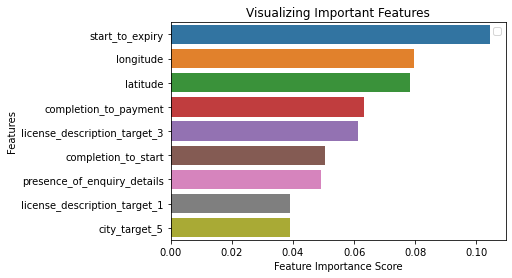

In [37]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [39]:
# Random Tree
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=1)
y_pred = rf_model.fit(X_train, y_train).predict(X_test)

In [104]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [40]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       877
           1       0.93      0.91      0.92      1688
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       0.94      0.83      0.88        70

    accuracy                           0.90      2696
   macro avg       0.94      0.92      0.93      2696
weighted avg       0.90      0.90      0.90      2696



In [41]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, rf_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No handles with labels found to put in legend.


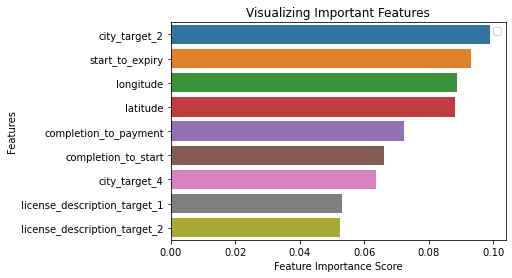

In [42]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [56]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(random_state=0)
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=0)

In [57]:
y_pred = ada_model.predict(X_test)

In [58]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       877
           1       0.80      0.84      0.82      1688
           2       0.00      0.00      0.00        31
           3       0.69      0.67      0.68        30
           4       0.00      0.00      0.00        70

    accuracy                           0.74      2696
   macro avg       0.42      0.43      0.43      2696
weighted avg       0.71      0.74      0.73      2696



C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
# xg Boost
from xgboost import XGBClassifier

In [60]:
X_train.shape

(24264, 22)

In [67]:
xg_model = XGBClassifier(random_state=1)
xg_model.fit(X_train, y_train)

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
y_pred = xg_model.predict(X_test)

In [69]:
from sklearn import metrics
metrics.f1_score(y_test,y_pred,average="macro")

0.9302760565719289

In [70]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       877
           1       0.93      0.92      0.92      1688
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       0.92      0.84      0.88        70

    accuracy                           0.90      2696
   macro avg       0.94      0.92      0.93      2696
weighted avg       0.90      0.90      0.90      2696



In [71]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, xg_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No handles with labels found to put in legend.


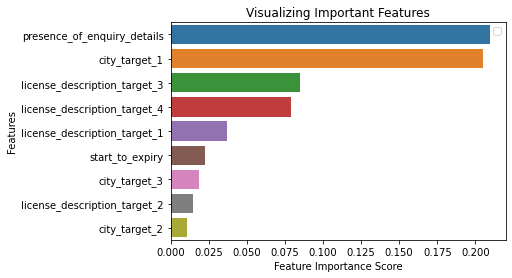

In [72]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# Hyperparameter Tuning - Tree parameters
1. No. of trees
2. Depth of the trees
3. Min no. of samples in the leaf node
4. Max number of features
5. Split Criterion 

In [75]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [125]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,10]

In [126]:
n_estimators

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [127]:
max_depth

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]

In [184]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_leaf':[1]
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [1]}


In [185]:
rf_random = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = random_grid, n_iter = 10, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

In [186]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [187]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90}

In [188]:
rf_model_tuned = RandomForestClassifier(**best_params_)

In [189]:
rf_model_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=90, max_features='sqrt', min_samples_split=5,
                       n_estimators=200, random_state=1)

In [190]:
y_pred = rf_model_tuned.predict(X_test)

In [191]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       877
           1       0.94      0.91      0.93      1688
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       0.93      0.73      0.82        70

    accuracy                           0.90      2696
   macro avg       0.94      0.90      0.92      2696
weighted avg       0.90      0.90      0.90      2696



In [192]:
from sklearn.model_selection import GridSearchCV

In [196]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50,100,150,None],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2,4,5,6],
    'n_estimators': [50,100,150,200]
}

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [197]:
4*3*4*4*3

576

In [198]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150, None],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [199]:
grid_search.best_params_

{'max_depth': 50,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [200]:
rf_grid_tuned = RandomForestClassifier(**grid_search.best_params_)

In [201]:
rf_grid_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=3, n_estimators=150)

In [202]:
y_pred = rf_grid_tuned.predict(X_test)

In [203]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       877
           1       0.93      0.91      0.92      1688
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        30
           4       0.91      0.60      0.72        70

    accuracy                           0.89      2696
   macro avg       0.93      0.88      0.90      2696
weighted avg       0.89      0.89      0.89      2696



In [47]:
# Hyper paramater tuning using hyper opt

In [204]:
from hyperopt import hp,fmin,tpe,Trials

In [205]:
# Create the parameter grid based on the results of random search 
param_grid_space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }

In [206]:
def optimize(param_grid_space):
    X_train,y_train,X_test,y_test
    xgbm = XGBClassifier(n_estimators =param_grid_space['n_estimators'], max_depth = int(param_grid_space['max_depth']),
                         gamma = param_grid_space['gamma']
                        )
    xgbm.fit(X_train, y_train)
    y_pred = xgbm.predict(X_test)
    f1score = metrics.f1_score(y_test,y_pred,average="macro")
    return -1*f1score

In [207]:
trial = Trials()
result = fmin(fn=optimize,space=param_grid_space,max_evals=3,trials=trial,algo=tpe.suggest)


[16:49:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



 33%|████████████████▎                                | 1/3 [00:15<00:31, 15.61s/trial, best loss: -0.8665385724510548]

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[16:49:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:50:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 67%|████████████████████████████████▋                | 2/3 [00:41<00:21, 21.80s/trial, best loss: -0.8909281513947311]

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



100%|█████████████████████████████████████████████████| 3/3 [00:51<00:00, 17.27s/trial, best loss: -0.8909281513947311]


In [208]:
print(result)

{'colsample_bytree': 0.8276876468031019, 'gamma': 5.758469801098624, 'max_depth': 7.0, 'min_child_weight': 2.0, 'reg_alpha': 95.0, 'reg_lambda': 0.08138061941029084}


In [209]:
result["max_depth"] = int(result["max_depth"])

In [210]:
xg_model = XGBClassifier(**result)
xg_model.fit(X_train, y_train)

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8276876468031019,
              gamma=5.758469801098624, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, min_child_weight=2.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=95.0, reg_lambda=0.08138061941029084,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [211]:
y_pred = xg_model.predict(X_test)

In [212]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       877
           1       0.92      0.90      0.91      1688
           2       1.00      1.00      1.00        31
           3       1.00      0.67      0.80        30
           4       0.82      0.33      0.47        70

    accuracy                           0.86      2696
   macro avg       0.90      0.75      0.80      2696
weighted avg       0.87      0.86      0.86      2696

